In [3]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
%matplotlib inline

In [4]:
train = pd.read_csv("Desktop/MNIST/train_resized.csv")
test = pd.read_csv("Desktop/MNIST/test_resized.csv")
# train.isnull().sum().sort_values(ascending=False)
# test.isnull().sum().sort_values(ascending=False)

In [5]:
x_train=train.drop(columns=["label"])
y_train=train["label"]
X_train=(x_train.to_numpy()-min(x_train.min()))/(max(x_train.max())-min(x_train.min()))
X_train = X_train.reshape(-1, 12, 12, 1)
Y_train=y_train.to_numpy()

x_test=test.drop(columns=["label"])
y_test=test["label"]
X_test=(x_test.to_numpy()-min(x_test.min()))/(max(x_test.max())-min(x_test.min()))
X_test = X_test.reshape(-1, 12, 12, 1)
Y_test=y_test.to_numpy()

In [6]:
X_train.shape, Y_train.shape

((30000, 12, 12, 1), (30000,))

In [7]:
# one-hot encode the labels
Y_train = np_utils.to_categorical(Y_train, 10)
Y_train.shape

(30000, 10)

In [8]:
# define CNN 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(12,12,1)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=192, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=192, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 192)         221376    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 192)        

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

In [10]:
start = time.time()
history = model.fit(
    X_train, Y_train, 
    batch_size=100, 
    epochs=25,
    validation_split=0.1,
    callbacks=[reduce_lr],
    verbose=1, 
    shuffle=True)

Train on 27000 samples, validate on 3000 samples
Epoch 1/25
27000/27000 [==============================] - 234s 9ms/step - loss: 0.3691 - accuracy: 0.8798 - val_loss: 0.1300 - val_accuracy: 0.9600
Epoch 2/25
27000/27000 [==============================] - 243s 9ms/step - loss: 0.0809 - accuracy: 0.9759 - val_loss: 0.0844 - val_accuracy: 0.9737
Epoch 3/25
27000/27000 [==============================] - 216s 8ms/step - loss: 0.0554 - accuracy: 0.9838 - val_loss: 0.0579 - val_accuracy: 0.9810
Epoch 4/25
27000/27000 [==============================] - 209s 8ms/step - loss: 0.0466 - accuracy: 0.9847 - val_loss: 0.0539 - val_accuracy: 0.9817
Epoch 5/25
27000/27000 [==============================] - 207s 8ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.0635 - val_accuracy: 0.9813
Epoch 6/25
27000/27000 [==============================] - 208s 8ms/step - loss: 0.0311 - accuracy: 0.9907 - val_loss: 0.0499 - val_accuracy: 0.9833
Epoch 7/25
27000/27000 [==============================] - 209s 

In [12]:
end = time.time()
print("Time cose:", end-start)

Time cose: 5301.895257949829


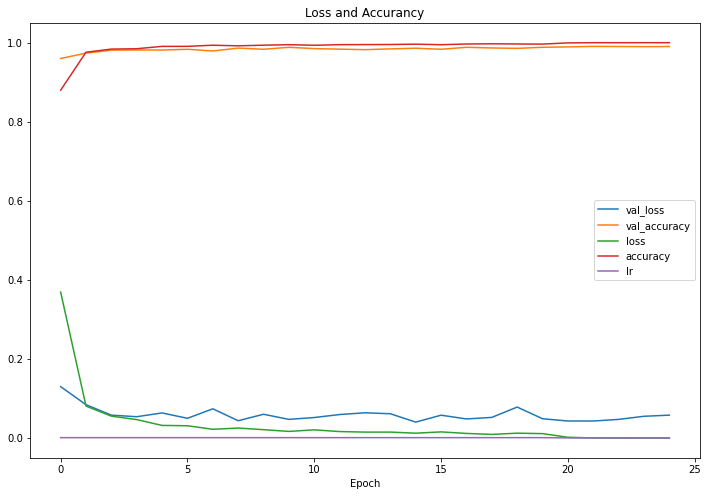

In [14]:
pd.DataFrame(history.history).plot(figsize = (12, 8))
plt.xlabel('Epoch')
plt.title('Loss and Accurancy')
plt.show()

In [15]:
loss, accuracy = model.evaluate(X_train,Y_train, verbose=2)
print('loss:',loss)
print('accuracy:',accuracy)

loss: 0.005794363296705715
accuracy: 0.9990333318710327


In [17]:
from sklearn.metrics import confusion_matrix
pred = model.predict_classes(X_test, verbose=2)
conf = confusion_matrix(Y_test, pred)

In [24]:
accuracy = np.sum(conf.diagonal())/np.sum(conf)
error = 1-accuracy
print('The accuracy in test dataset: ', np.round(accuracy*100,3), '%', sep='')
print('The misclassification error in test dataset:', np.round(error*100, 3), '%', sep='')

The accuracy in test dataset: 99.025%
The misclassification error in test dataset:0.975%


In [29]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

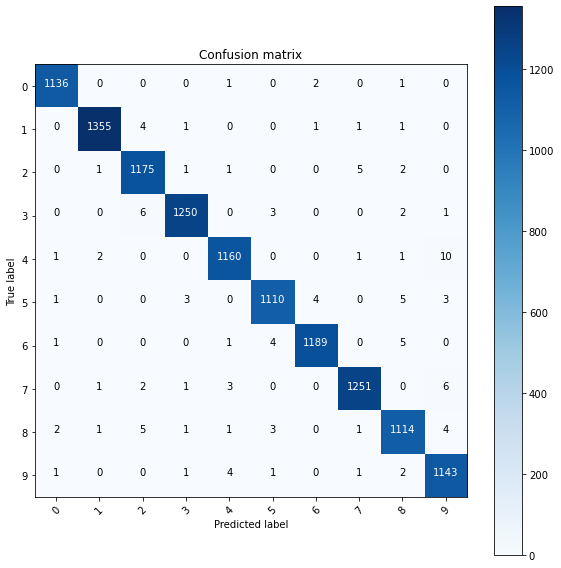

In [32]:
plt.figure(figsize = (8, 8))
# plt.grid(b=None)
plot_confusion_matrix(conf, classes = range(10))